# Python: Panel Data with Multiple Time Periods

In this example, a detailed guide on Difference-in-Differences with multiple time periods using the [DoubleML-package](https://docs.doubleml.org/stable/index.html). The implementation is based on [Callaway and Sant'Anna(2021)](https://doi.org/10.1016/j.jeconom.2020.12.001).

The notebook requires the following packages:

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from doubleml.did import DoubleMLDIDMulti
from doubleml.data import DoubleMLPanelData

from doubleml.did.datasets import make_did_CS2021

## Data

We will rely on the `make_did_CS2021` DGP, which is inspired by [Callaway and Sant'Anna(2021)](https://doi.org/10.1016/j.jeconom.2020.12.001) (Appendix SC) and [Sant'Anna and Zhao (2020)](https://doi.org/10.1016/j.jeconom.2020.06.003).

We will observe `n_obs` units over `n_periods`. Remark that the dataframe includes observations of the potential outcomes `y0` and `y1`, such that we can use oracle estimates as comparisons. 

In [2]:
n_obs = 5000
n_periods = 6

df = make_did_CS2021(n_obs, dgp_type=4, n_periods=n_periods, n_pre_treat_periods=3, time_type="datetime")
df["ite"] = df["y1"] - df["y0"]

print(df.shape)
df.head()

(30000, 11)


,id,y,y0,y1,d,t,Z1,Z2,Z3,Z4,ite
0,0,211.043114,211.043114,210.347791,2025-04-01,2025-01-01,0.204845,0.021681,-0.08159,-0.329794,-0.695324
1,0,213.421217,213.421217,215.872595,2025-04-01,2025-02-01,0.204845,0.021681,-0.08159,-0.329794,2.451378
2,0,215.066804,215.066804,215.847357,2025-04-01,2025-03-01,0.204845,0.021681,-0.08159,-0.329794,0.780554
3,0,220.781501,217.943028,220.781501,2025-04-01,2025-04-01,0.204845,0.021681,-0.08159,-0.329794,2.838473
4,0,222.620521,222.167317,222.620521,2025-04-01,2025-05-01,0.204845,0.021681,-0.08159,-0.329794,0.453205


### Data Details

Here, we slightly abuse the definition of the potential outcomes. $Y_{i,t}(1)$ corresponds to the (potential) outcome if unit $i$ would have received treatment at time period $\mathrm{g}$ (where the group $\mathrm{g}$ is drawn with probabilities based on $Z$).

More specifically

$$
\begin{align*}
Y_{i,t}(0)&:= f_t(Z) + \delta_t + \eta_i + \varepsilon_{i,t,0}\\
Y_{i,t}(1)&:= Y_{i,t}(0) + \theta_{i,t,\mathrm{g}} + \epsilon_{i,t,1} - \epsilon_{i,t,0}
\end{align*}
$$

where
 - $f_t(Z)$ depends on pre-treatment observable covariates $Z_1,\dots, Z_4$ and time $t$
 - $\delta_t$ is a time fixed effect
 - $\eta_i$ is a unit fixed effect
 - $\epsilon_{i,t,\cdot}$ are time varying unobservables (iid. $N(0,1)$)
 - $\theta_{i,t,\mathrm{g}}$ correponds to the exposure effect of unit $i$ based on group $\mathrm{g}$ at time $t$

For the pre-treatment periods the exposure effect is set to
$$
\theta_{i,t,\mathrm{g}}:= 0 \text{ for } t<\mathrm{g}
$$
such that 

$$
\mathbb{E}[Y_{i,t}(1) - Y_{i,t}(0)] = \mathbb{E}[\epsilon_{i,t,1} - \epsilon_{i,t,0}]=0  \text{ for } t<\mathrm{g}
$$

The [DoubleML Coverage Repository](https://docs.doubleml.org/doubleml-coverage/) includes coverage simulations based on this DGP.

### Data Description

The data is a balanced panel where each unit is observed over `n_periods` starting Janary 2025.

In [3]:
df.groupby("t").size()

t
2025-01-01    5000
2025-02-01    5000
2025-03-01    5000
2025-04-01    5000
2025-05-01    5000
2025-06-01    5000
dtype: int64

The treatment column `d` indicates first treatment period of the corresponding unit, whereas `NaT` units are never treated.

*Generally, never treated units should take either on the value `np.inf` or `pd.NaT` depending on the data type (`float` or `datetime`).*

The individual units are roughly uniformly divided between the groups, where treatment assignment depends on the pre-treatment covariates `Z1` to `Z4`.

In [4]:
df.groupby("d", dropna=False).size()

d
2025-04-01    7878
2025-05-01    7608
2025-06-01    7188
NaT           7326
dtype: int64

Here, the group indicates the first treated period and `NaT` units are never treated. To simplify plotting and pands

In [5]:
df.groupby("d", dropna=False).size()

d
2025-04-01    7878
2025-05-01    7608
2025-06-01    7188
NaT           7326
dtype: int64

To get a better understanding of the underlying data and true effects, we will compare the unconditional averages and the true effects based on the oracle values of individual effects `ite`.

In [6]:
# rename for plotting
df["First Treated"] = df["d"].dt.strftime("%Y-%m").fillna("Never Treated")

# Create aggregation dictionary for means
def agg_dict(col_name):
    return {
        f'{col_name}_mean': (col_name, 'mean'),
        f'{col_name}_lower_quantile': (col_name, lambda x: x.quantile(0.05)),
        f'{col_name}_upper_quantile': (col_name, lambda x: x.quantile(0.95))
    }

# Calculate means and confidence intervals
agg_dictionary = agg_dict("y") | agg_dict("ite")

agg_df = df.groupby(["t", "First Treated"]).agg(**agg_dictionary).reset_index()
agg_df.head()

,t,First Treated,y_mean,y_lower_quantile,y_upper_quantile,ite_mean,ite_lower_quantile,ite_upper_quantile
0,2025-01-01,2025-04,208.694311,198.680350,218.845753,0.008746,-2.329862,2.277889
1,2025-01-01,2025-05,211.001204,200.475258,221.168663,0.029495,-2.329645,2.332089
2,2025-01-01,2025-06,212.591735,202.521631,222.284369,0.013721,-2.165674,2.458061
3,2025-01-01,Never Treated,214.435194,203.853285,224.883206,0.012033,-2.247881,2.249316
4,2025-02-01,2025-04,208.430491,188.640684,228.143035,-0.025133,-2.353847,2.389118


In [7]:
def plot_data(df, col_name='y'):
    """
    Create an improved plot with colorblind-friendly features
    
    Parameters:
    -----------
    df : DataFrame
        The dataframe containing the data
    col_name : str, default='y'
        Column name to plot (will use '{col_name}_mean')
    """
    plt.figure(figsize=(12, 7))
    n_colors = df["First Treated"].nunique()
    color_palette = sns.color_palette("colorblind", n_colors=n_colors)

    sns.lineplot(
        data=df,
        x='t',
        y=f'{col_name}_mean',
        hue='First Treated',
        style='First Treated',
        palette=color_palette,
        markers=True,
        dashes=True,
        linewidth=2.5,
        alpha=0.8
    )
    
    plt.title(f'Average Values {col_name} by Group Over Time', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel(f'Average Value {col_name}', fontsize=14)
    

    plt.legend(title='First Treated', title_fontsize=13, fontsize=12, 
               frameon=True, framealpha=0.9, loc='best')
    
    plt.grid(alpha=0.3, linestyle='-')
    plt.tight_layout()

    plt.show()

So let us take a look at the average values over time

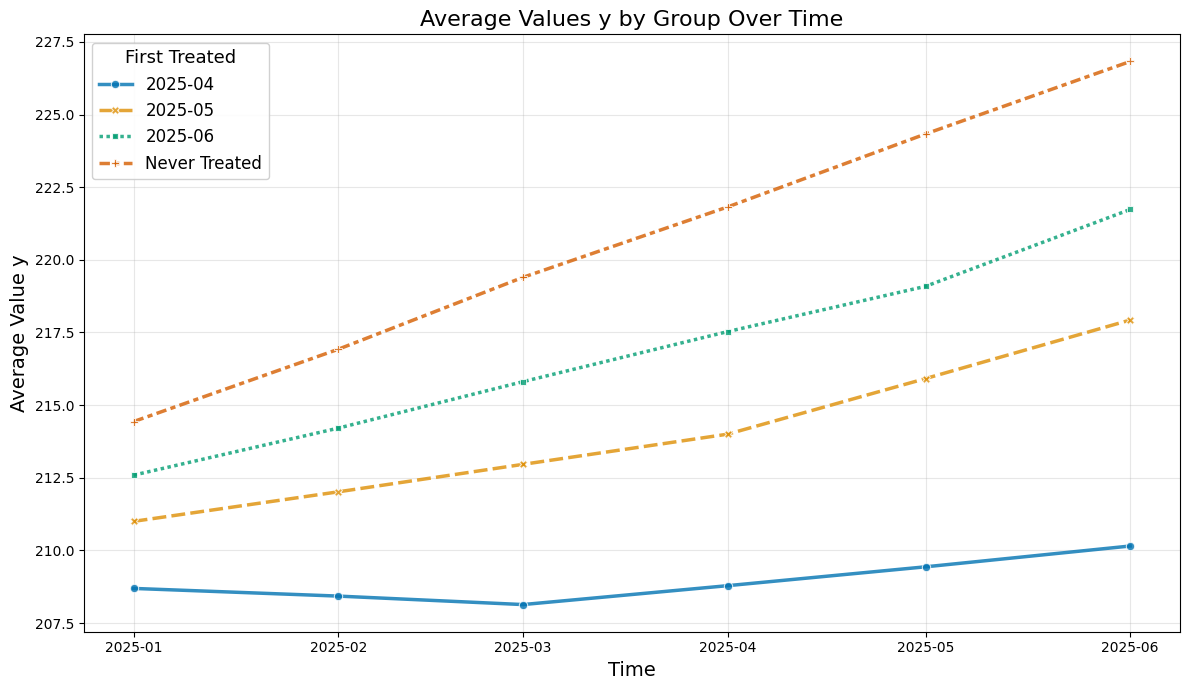

In [8]:
plot_data(agg_df, col_name='y')

Instead the true average treatment treatment effects can be obtained by averaging (usually unobserved) the `ite` values.

The true effect just equals the exposure time (in months):

$$
ATT(\mathrm{g}, t) = \min(\mathrm{t} - \mathrm{g} + 1, 0) =: e
$$


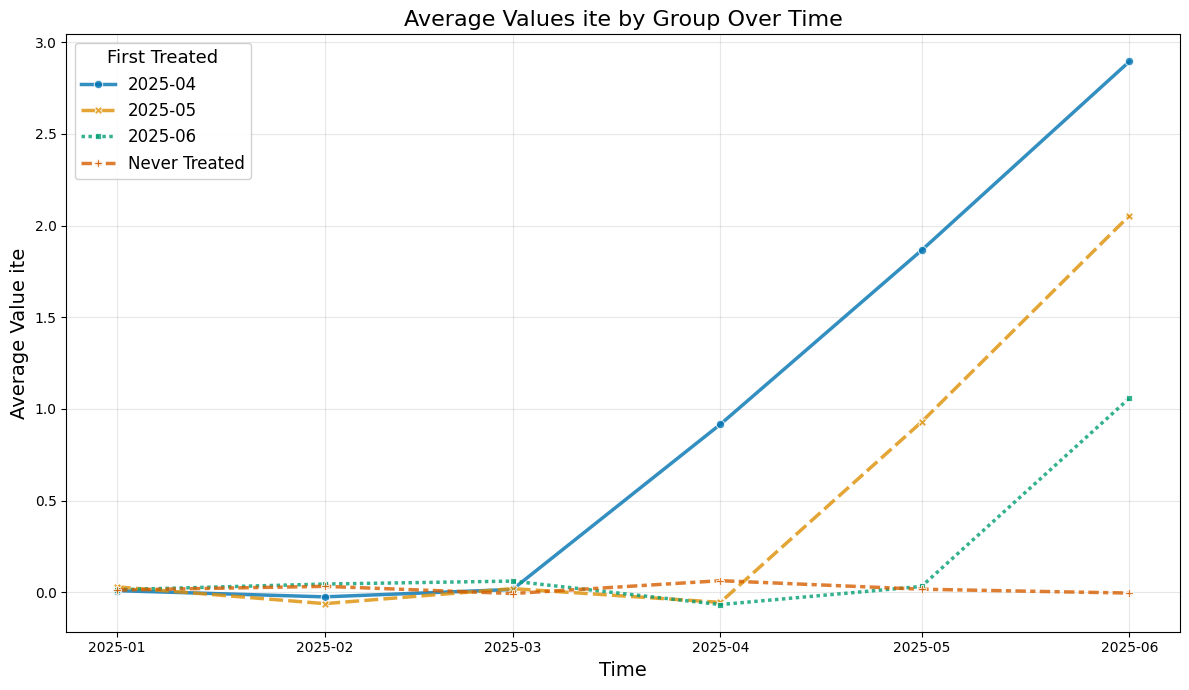

In [9]:
plot_data(agg_df, col_name='ite')

### DoubleMLPanelData

Finally, we can construct our `DoubleMLPanelData`, specifying

 - `y_col` : the outcome
 - `d_cols`: the group variable indicating the first treated period for each unit
 - `id_col`: the unique identification column for each unit
 - `t_col` : the time column
 - `x_cols`: the additional pre-treatment controls
 - `datetime_unit`: unit required for `datetime` columns and plotting

In [10]:
dml_data = DoubleMLPanelData(
    data=df,
    y_col="y",
    d_cols="d",
    id_col="id",
    t_col="t",
    x_cols=["Z1", "Z2", "Z3", "Z4"],
    datetime_unit="M"
)
print(dml_data)

================== DoubleMLPanelData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['Z1', 'Z2', 'Z3', 'Z4']
Instrument variable(s): None
Time variable: t
Id variable: id
No. Unique Ids: 5000
No. Observations: 30000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 12 entries, id to First Treated
dtypes: datetime64[s](2), float64(8), int64(1), object(1)
memory usage: 2.7+ MB



## ATT Estimation

The [DoubleML-package](https://docs.doubleml.org/stable/index.html) implements estimation of group-time average treatment effect via the `DoubleMLDIDMulti` class (see [model documentation](https://docs.doubleml.org/stable/guide/models.html#difference-in-differences-models-did)).

### Basics

The class basically behaves like other `DoubleML` classes and requires the specification of two learners (for more details on the regression elements, see [score documentation](https://docs.doubleml.org/stable/guide/scores.html#difference-in-differences-models)).

The basic arguments of a `DoubleMLDIDMulti` object include

 - `ml_g` "outcome" regression learner
 - `ml_m` propensity Score learner
 - `control_group` the control group for the parallel trend assumption
 - `gt_combinations` combinations of $(\mathrm{g},t_\text{pre}, t_\text{eval})$
 - `anticipation_periods` number of anticipation periods

We will construct a `dict` with "default" arguments.

In [11]:
default_args = {
    "ml_g": LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=-1, random_state=123),
    "ml_m": LGBMClassifier(n_estimators=500, learning_rate=0.01, verbose=-1, random_state=123),
    "control_group": "never_treated",
    "gt_combinations": "standard",
    "anticipation_periods": 0,
    "n_folds": 5,
    "n_rep": 1,
}

 The model will be estimated using the `fit()` method.

In [12]:
np.random.seed(42)
dml_obj = DoubleMLDIDMulti(dml_data, **default_args)
dml_obj.fit()
print(dml_obj)

/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['Z1', 'Z2', 'Z3', 'Z4']
Instrument variable(s): None
Time variable: t
Id variable: id
No. Unique Ids: 5000
No. Observations: 30000

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LGBMRegressor(learning_rate=0.01, n_estimators=500, random_state=123,
              verbose=-1)
Learner ml_m: LGBMClassifier(learning_rate=0.01, n_estimators=500, random_state=123,
               verbose=-1)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[1.96449822 1.9426512  1.94083177 2.79791666 3.93603637 1.93100805
  1.946417   1.95491828 1.89915168 2.90295312 1.93307048 1.9327322
  1.92088894 1.88830104 2.01649384]]
Learner ml_g1 RMSE: [[1.89096955 1.846

/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


The summary displays estimates of the $ATT(g,t_\text{eval})$ effects for different combinations of $(g,t_\text{eval})$ via $\widehat{ATT}(\mathrm{g},t_\text{pre},t_\text{eval})$, where
 - $\mathrm{g}$ specifies the group
 - $t_\text{pre}$ specifies the corresponding pre-treatment period
 - $t_\text{eval}$ specifies the evaluation period

The choice `gt_combinations="standard"`, used estimates all possible combinations of $ATT(g,t_\text{eval})$ via $\widehat{ATT}(\mathrm{g},t_\text{pre},t_\text{eval})$,
where the standard choice is $t_\text{pre} = \min(\mathrm{g}, t_\text{eval}) - 1$ (without anticipation).

Remark that this includes pre-tests effects if $\mathrm{g} > t_{eval}$, e.g. $\widehat{ATT}(g=\text{2025-04}, t_{\text{pre}}=\text{2025-01}, t_{\text{eval}}=\text{2025-02})$ which estimates the pre-trend from January to February even if the actual treatment occured in April.

As usual for the DoubleML-package, you can obtain joint confidence intervals via bootstrap.

In [13]:
level = 0.95

ci = dml_obj.confint(level=level)
dml_obj.bootstrap(n_rep_boot=5000)
ci_joint = dml_obj.confint(level=level, joint=True)
ci_joint

,2.5 %,97.5 %
"ATT(2025-04,2025-01,2025-02)",-0.295252,0.388366
"ATT(2025-04,2025-02,2025-03)",-0.517904,0.118701
"ATT(2025-04,2025-03,2025-04)",0.577957,1.236290
"ATT(2025-04,2025-03,2025-05)",1.116925,2.171764
"ATT(2025-04,2025-03,2025-06)",1.825459,3.542958
"ATT(2025-05,2025-01,2025-02)",-0.394945,0.221371
"ATT(2025-05,2025-02,2025-03)",-0.445529,0.144807
"ATT(2025-05,2025-03,2025-04)",-0.290657,0.292032
"ATT(2025-05,2025-04,2025-05)",0.447639,1.094939
"ATT(2025-05,2025-04,2025-06)",1.239942,2.212189


A visualization of the effects can be obtained via the `plot_effects()` method.

Remark that the plot used joint confidence intervals per default. 

/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


(<Figure size 1200x800 with 4 Axes>,
 [<Axes: title={'center': 'First Treated: 2025-04'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-05'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-06'}, xlabel='Evaluation Period', ylabel='Effect'>])

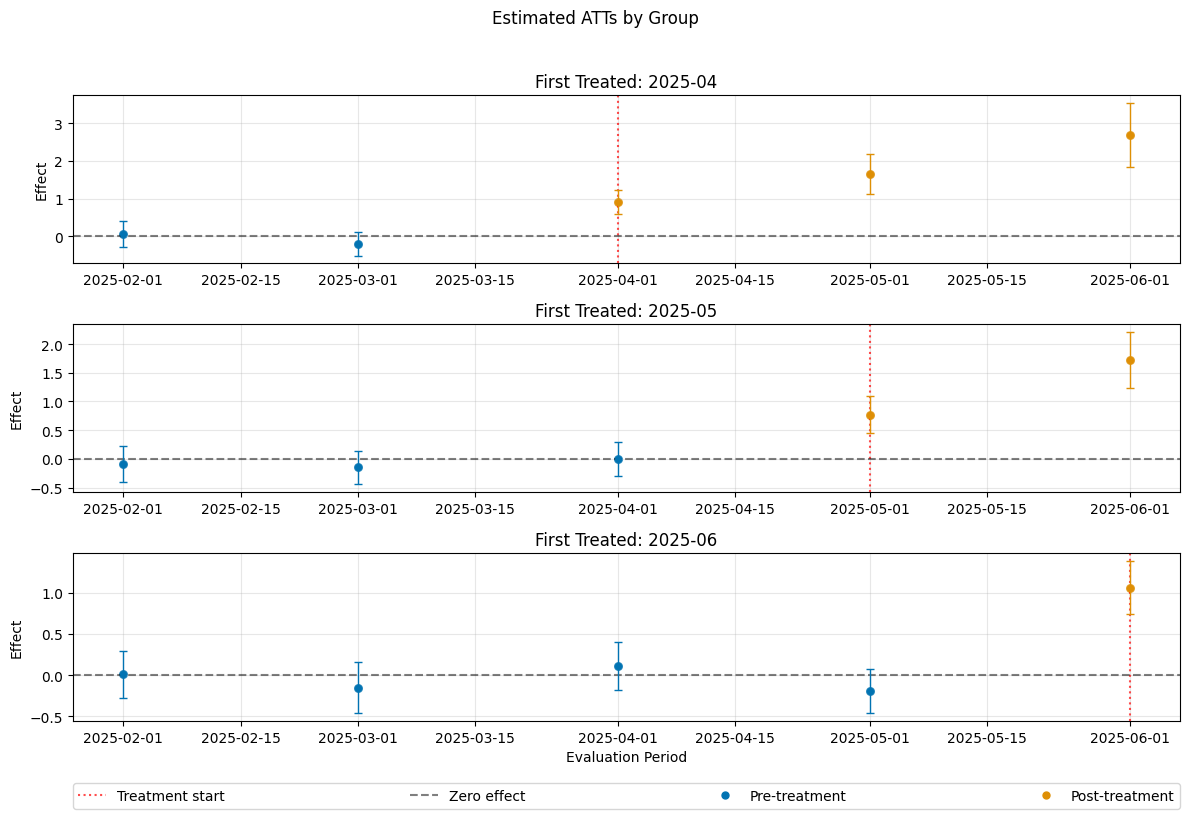

In [14]:
dml_obj.plot_effects()

### Sensitivity Analysis

As descripted in the [Sensitivity Guide](https://docs.doubleml.org/stable/guide/sensitivity.html), robustness checks on omitted confounding/parallel trend violations are available, via the standard `sensitivity_analysis()` method.

In [15]:
dml_obj.sensitivity_analysis()
print(dml_obj.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
                              CI lower  theta lower     theta  theta upper  \
ATT(2025-04,2025-01,2025-02) -0.234132    -0.054596  0.046557     0.147710   
ATT(2025-04,2025-02,2025-03) -0.485941    -0.302500 -0.199602    -0.096704   
ATT(2025-04,2025-03,2025-04)  0.613198     0.797957  0.907123     1.016290   
ATT(2025-04,2025-03,2025-05)  1.194409     1.489254  1.644344     1.799434   
ATT(2025-04,2025-03,2025-06)  2.018040     2.481988  2.684208     2.886429   
ATT(2025-05,2025-01,2025-02) -0.364263    -0.187064 -0.086787     0.013490   
ATT(2025-05,2025-02,2025-03) -0.428163    -0.260655 -0.150361    -0.040067   
ATT(2025-05,2025-03,2025-04) -0.278813    -0.113187  0.000687     0.114561   
ATT(2025-05,2025-04,2025-05)  0.479991  

In this example one can clearly, distinguish the robustness of the non-zero effects vs. the pre-treatment periods.

### Control Groups

The current implementation support the following control groups

 - ``"never_treated"``
 - ``"not_yet_treated"``

Remark that the ``"not_yet_treated" depends on anticipation.

For differences and recommendations, we refer to [Callaway and Sant'Anna(2021)](https://doi.org/10.1016/j.jeconom.2020.12.001).

/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


(<Figure size 1200x800 with 4 Axes>,
 [<Axes: title={'center': 'First Treated: 2025-04'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-05'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-06'}, xlabel='Evaluation Period', ylabel='Effect'>])

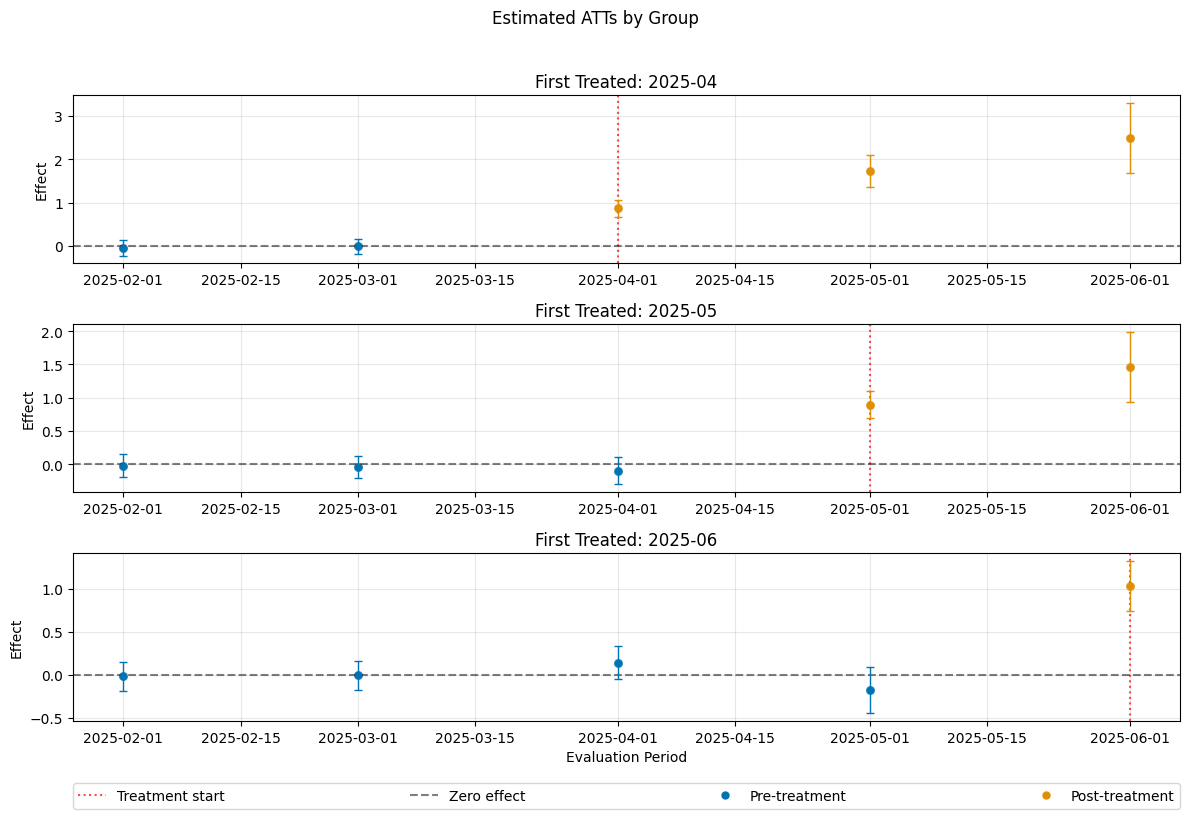

In [16]:
dml_obj_nyt = DoubleMLDIDMulti(dml_data, **(default_args | {"control_group": "not_yet_treated"}))
dml_obj_nyt.fit()
dml_obj_nyt.bootstrap(n_rep_boot=5000)
dml_obj_nyt.plot_effects()

### Linear Covariate Adjustment

Remark that we relied on boosted trees to adjust for conditional parallel trends which allow for a nonlinear adjustment. In comparison to linear adjustment, we could rely on linear learners.

**Remark that the DGP (`dgp_type=4`) is based on nonlinear conditional expectations such that the estimates will be biased**



/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


(<Figure size 1200x800 with 4 Axes>,
 [<Axes: title={'center': 'First Treated: 2025-04'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-05'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-06'}, xlabel='Evaluation Period', ylabel='Effect'>])

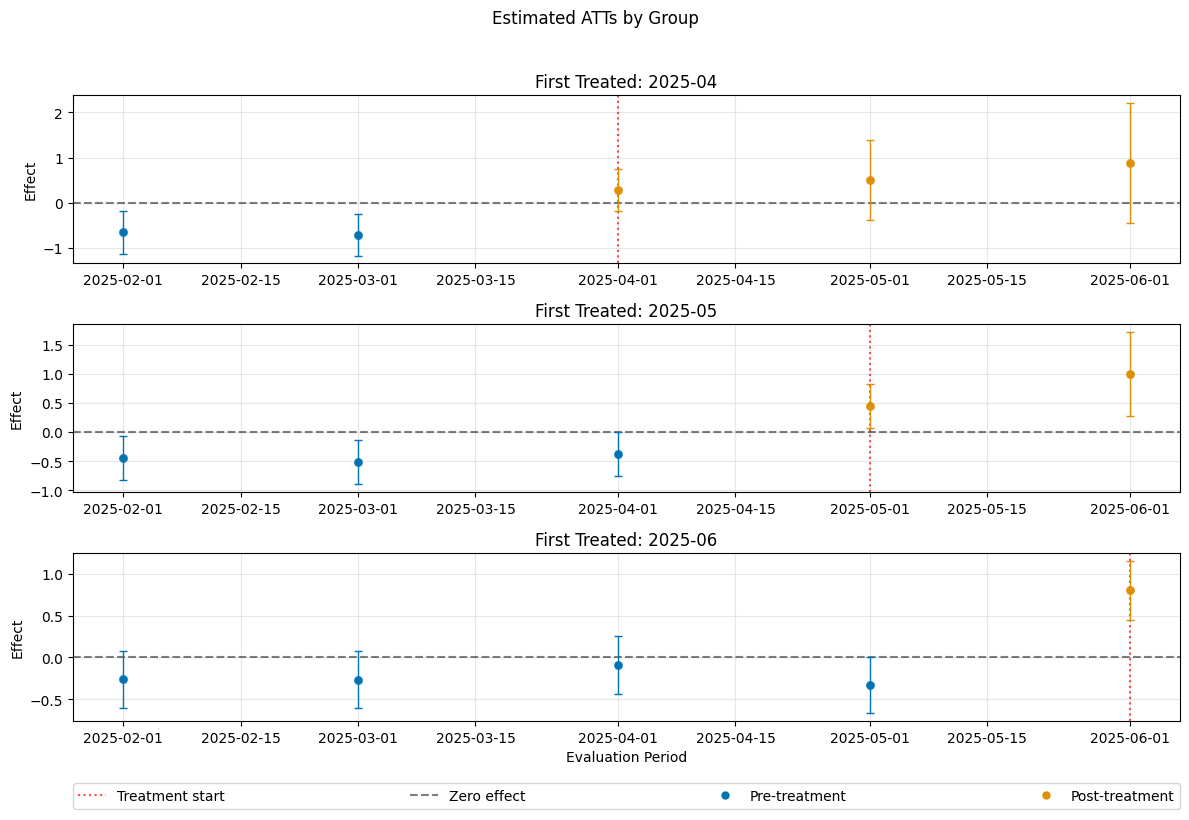

In [17]:
linear_learners = {
    "ml_g": LinearRegression(),
    "ml_m": LogisticRegression(),
}

dml_obj_linear = DoubleMLDIDMulti(dml_data, **(default_args | linear_learners))
dml_obj_linear.fit()
dml_obj_linear.bootstrap(n_rep_boot=5000)
dml_obj_linear.plot_effects()

## Aggregated Effects
As the [did-R-package](https://bcallaway11.github.io/did/index.html), the $ATT$'s can be aggregated to summarize multiple effects.
For details on different aggregations and details on their interpretations see [Callaway and Sant'Anna(2021)](https://doi.org/10.1016/j.jeconom.2020.12.001).

The aggregations are implemented via the `aggregate()` method.

### Group Aggregation


To obtain group-specific effects one can would like to average $ATT(\mathrm{g}, t_\text{eval})$ over $t_\text{eval}$.
As a sample oracle we will combine all `ite`'s based on group $\mathrm{g}$.

In [18]:
df_post_treatment = df[df["t"] >= df["d"]]
df_post_treatment.groupby("d")["ite"].mean()

d
2025-04-01    1.892230
2025-05-01    1.491633
2025-06-01    1.058554
Name: ite, dtype: float64

To obtain group-specific effects it is possible to aggregate several $\widehat{ATT}(\mathrm{g},t_\text{pre},t_\text{eval})$ values based on the group $\mathrm{g}$ by setting the `aggregation="group"` argument.

================== DoubleMLDIDAggregation Object ==================
 Group Aggregation 

------------------ Overall Aggregated Effects ------------------
   coef  std err         t  P>|t|    2.5 %   97.5 %
1.36261 0.111131 12.261259    0.0 1.144796 1.580423
------------------ Aggregated Effects         ------------------
             coef   std err         t  P>|t|     2.5 %    97.5 %
2025-04  1.745225  0.176151  9.907557    0.0  1.399976  2.090475
2025-05  1.248677  0.128986  9.680730    0.0  0.995870  1.501485
2025-06  1.063855  0.112070  9.492811    0.0  0.844202  1.283507
------------------ Additional Information     ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0



/home/runner/work/doubleml-docs/doubleml-docs/doubleml-for-py/doubleml/did/did_aggregation.py:368: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


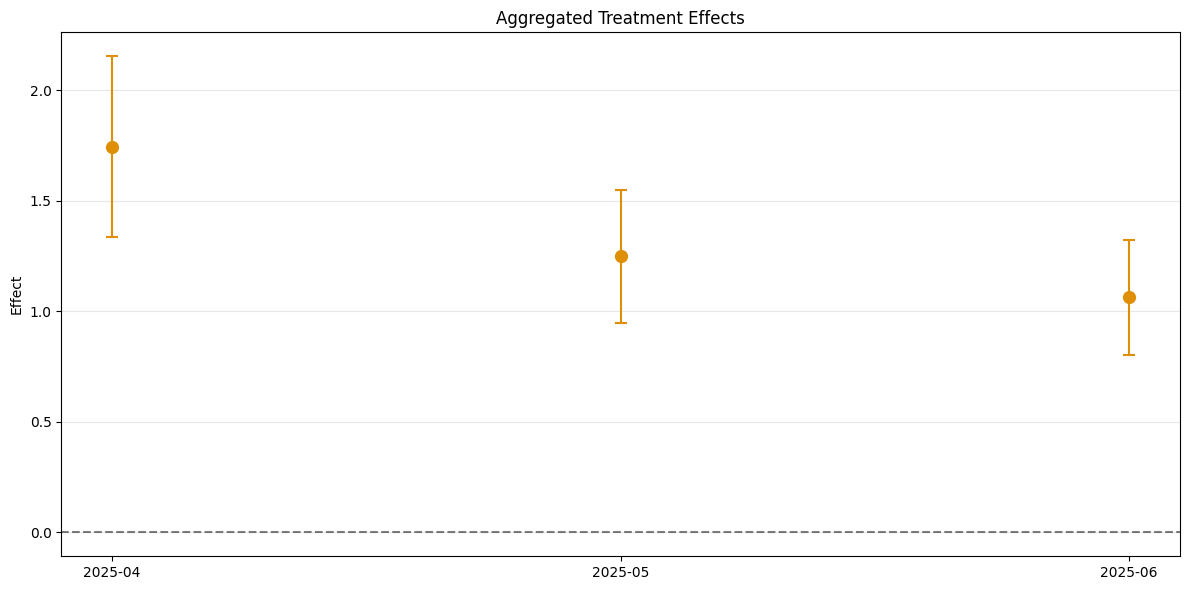

In [19]:
aggregated_group = dml_obj.aggregate(aggregation="group")
print(aggregated_group)
_ = aggregated_group.plot_effects()

The output is a `DoubleMLDIDAggregation` object which includes an overall aggregation summary based on group size.

### Time Aggregation

To obtain time-specific effects one can would like to average $ATT(\mathrm{g}, t_\text{eval})$ over $\mathrm{g}$ (respecting group size).
As a sample oracle we will combine all `ite`'s based on group $\mathrm{g}$. As oracle values, we obtain

In [20]:
df_post_treatment.groupby("t")["ite"].mean()

t
2025-04-01    0.916087
2025-05-01    1.405104
2025-06-01    2.030967
Name: ite, dtype: float64

To aggregate $\widehat{ATT}(\mathrm{g},t_\text{pre},t_\text{eval})$, based on $t_\text{eval}$, but weighted with respect to group size. Corresponds to *Calendar Time Effects* from the [did-R-package](https://bcallaway11.github.io/did/index.html).

For calendar time effects set `aggregation="time"`.

================== DoubleMLDIDAggregation Object ==================
 Time Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.323863 0.116124 11.400465    0.0 1.096265 1.551461
------------------ Aggregated Effects         ------------------
             coef   std err          t         P>|t|     2.5 %    97.5 %
2025-04  0.907123  0.113505   7.991945  1.332268e-15  0.684658  1.129589
2025-05  1.215428  0.128851   9.432833  0.000000e+00  0.962885  1.467970
2025-06  1.849038  0.159735  11.575671  0.000000e+00  1.535963  2.162113
------------------ Additional Information     ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0



/home/runner/work/doubleml-docs/doubleml-docs/doubleml-for-py/doubleml/did/did_aggregation.py:368: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


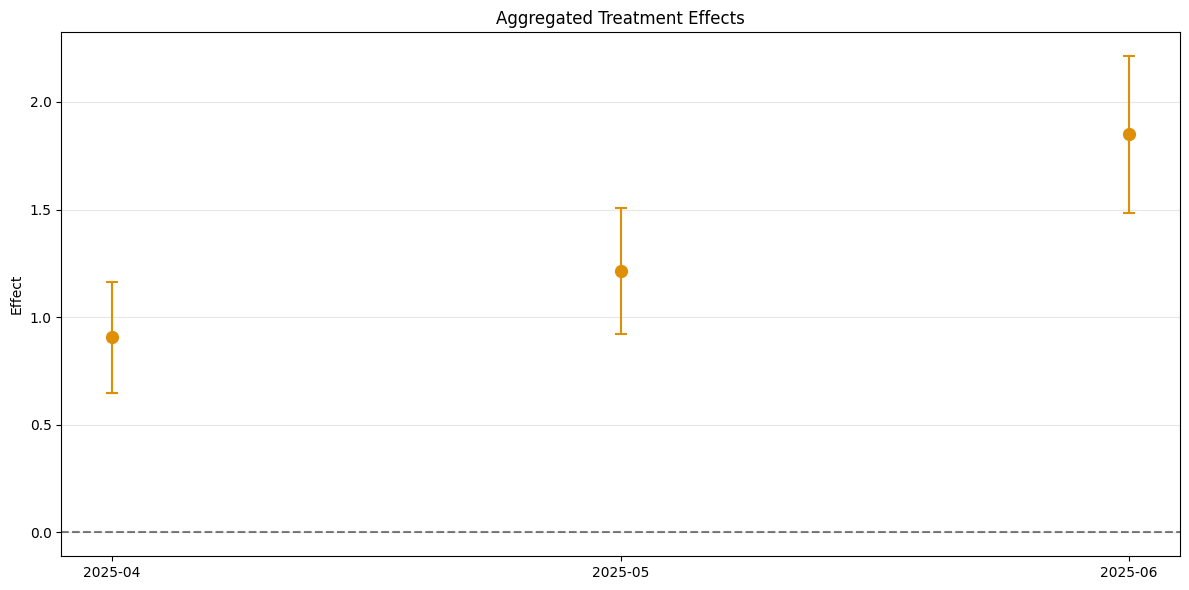

In [21]:
aggregated_time = dml_obj.aggregate("time")
print(aggregated_time)
fig, ax = aggregated_time.plot_effects()

### Event Study Aggregation

To obtain event-study-type effects one can would like to aggregate $ATT(\mathrm{g}, t_\text{eval})$ over $e = t_\text{eval} - \mathrm{g}$ (respecting group size).
As a sample oracle we will combine all `ite`'s based on group $\mathrm{g}$. As oracle values, we obtain

In [22]:
df["e"] = pd.to_datetime(df["t"]).values.astype("datetime64[M]") - \
    pd.to_datetime(df["d"]).values.astype("datetime64[M]")
df.groupby("e")["ite"].mean()[1:]

e
-122 days    0.036933
-92 days     0.001485
-61 days    -0.023422
-31 days    -0.003156
0 days       0.965500
31 days      1.958173
59 days      2.895470
Name: ite, dtype: float64

Analogously, `aggregation="eventstudy"` aggregates $\widehat{ATT}(\mathrm{g},t_\text{pre},t_\text{eval})$ based on exposure time $e = t_\text{eval} - \mathrm{g}$ (respecting group size).

================== DoubleMLDIDAggregation Object ==================
 Event Study Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.759978 0.159299 11.048278    0.0 1.447758 2.072198
------------------ Aggregated Effects         ------------------
               coef   std err          t     P>|t|     2.5 %    97.5 %
-4 months  0.010931  0.097931   0.111619  0.911126 -0.181010  0.202872
-3 months -0.117645  0.081198  -1.448861  0.147376 -0.276790  0.041501
-2 months  0.000686  0.070255   0.009770  0.992205 -0.137011  0.138383
-1 months -0.130879  0.066706  -1.962035  0.049758 -0.261621 -0.000138
0 months   0.911232  0.078401  11.622767  0.000000  0.757570  1.064894
1 months   1.684492  0.149550  11.263730  0.000000  1.391380  1.977605
2 months   2.684208  0.296118   9.064660  0.000000  2.103828  3.264589
------------------ Additional Information     ------------------
Score function: observational
Contro

/home/runner/work/doubleml-docs/doubleml-docs/doubleml-for-py/doubleml/did/did_aggregation.py:368: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Aggregated Treatment Effects'}, ylabel='Effect'>)

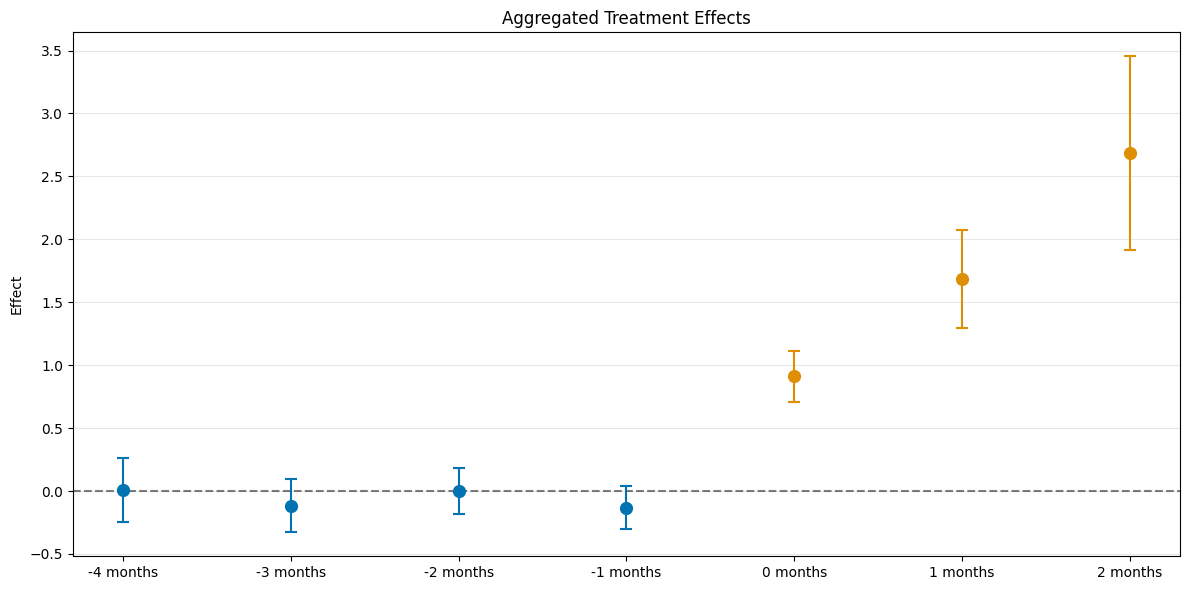

In [23]:
aggregated_eventstudy = dml_obj.aggregate("eventstudy")
print(aggregated_eventstudy)
aggregated_eventstudy.plot_effects()

### Aggregation Details

The `DoubleMLDIDAggregation` objects include several `DoubleMLFrameworks` which support methods like `bootstrap()` or `confint()`.
Further, the weights can be accessed via the properties

 - ``overall_aggregation_weights``: weights for the overall aggregation
 - ``aggregation_weights``: weights for the aggregation

To clarify, e.g. for the eventstudy aggregation

In [24]:
print(aggregated_eventstudy)

================== DoubleMLDIDAggregation Object ==================
 Event Study Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.759978 0.159299 11.048278    0.0 1.447758 2.072198
------------------ Aggregated Effects         ------------------
               coef   std err          t     P>|t|     2.5 %    97.5 %
-4 months  0.010931  0.097931   0.111619  0.911126 -0.181010  0.202872
-3 months -0.117645  0.081198  -1.448861  0.147376 -0.276790  0.041501
-2 months  0.000686  0.070255   0.009770  0.992205 -0.137011  0.138383
-1 months -0.130879  0.066706  -1.962035  0.049758 -0.261621 -0.000138
0 months   0.911232  0.078401  11.622767  0.000000  0.757570  1.064894
1 months   1.684492  0.149550  11.263730  0.000000  1.391380  1.977605
2 months   2.684208  0.296118   9.064660  0.000000  2.103828  3.264589
------------------ Additional Information     ------------------
Score function: observational
Contro

Here, the overall effect aggregation aggregates each effect with positive exposure

In [25]:
print(aggregated_eventstudy.overall_aggregation_weights)

[0.         0.         0.         0.         0.33333333 0.33333333
 0.33333333]


If one would like to consider how the aggregated effect with $e=0$ is computed, one would have to look at the corresponding set of weights within the ``aggregation_weights`` property

In [26]:
# the weights for e=0 correspond to the fifth element of the aggregation weights
aggregated_eventstudy.aggregation_weights[4]

array([0.        , 0.        , 0.34744641, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.3355385 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.31701508])

Taking a look at the original `dml_obj`, one can see that this combines the following estimates (only show month):

 - $\widehat{ATT}(04,03,04)$
 - $\widehat{ATT}(05,04,05)$
 - $\widehat{ATT}(06,05,06)$

In [27]:
print(dml_obj.summary["coef"])

ATT(2025-04,2025-01,2025-02)    0.046557
ATT(2025-04,2025-02,2025-03)   -0.199602
ATT(2025-04,2025-03,2025-04)    0.907123
ATT(2025-04,2025-03,2025-05)    1.644344
ATT(2025-04,2025-03,2025-06)    2.684208
ATT(2025-05,2025-01,2025-02)   -0.086787
ATT(2025-05,2025-02,2025-03)   -0.150361
ATT(2025-05,2025-03,2025-04)    0.000687
ATT(2025-05,2025-04,2025-05)    0.771289
ATT(2025-05,2025-04,2025-06)    1.726065
ATT(2025-06,2025-01,2025-02)    0.010931
ATT(2025-06,2025-02,2025-03)   -0.150306
ATT(2025-06,2025-03,2025-04)    0.110286
ATT(2025-06,2025-04,2025-05)   -0.194814
ATT(2025-06,2025-05,2025-06)    1.063855
Name: coef, dtype: float64


## Anticipation

As described in the [Model Guide](https://docs.doubleml.org/stable/guide/models.html#difference-in-differences-models-did), one can include anticipation periods $\delta>0$ by setting the `anticipation_periods` parameter.

### Data with Anticipation

The DGP allows to include anticipation periods via the `anticipation_periods` parameter.
In this case the observations will be "shifted" such that units anticipate the effect earlier and the exposure effect is increased by the number of periods where the effect is anticipated.

In [28]:
n_obs = 4000
n_periods = 6

df_anticipation = make_did_CS2021(n_obs, dgp_type=4, n_periods=n_periods, n_pre_treat_periods=3, time_type="datetime", anticipation_periods=1)

print(df_anticipation.shape)
df_anticipation.head()


(19554, 10)


,id,y,y0,y1,d,t,Z1,Z2,Z3,Z4
1,0,222.705878,222.705878,221.313564,2025-05-01,2025-01-01,-0.585548,2.44869,-0.37197,2.143994
2,0,229.419102,229.419102,227.876223,2025-05-01,2025-02-01,-0.585548,2.44869,-0.37197,2.143994
3,0,235.741856,235.741856,233.069711,2025-05-01,2025-03-01,-0.585548,2.44869,-0.37197,2.143994
4,0,243.502719,239.883509,243.502719,2025-05-01,2025-04-01,-0.585548,2.44869,-0.37197,2.143994
5,0,248.897645,247.844788,248.897645,2025-05-01,2025-05-01,-0.585548,2.44869,-0.37197,2.143994


To visualize the anticipation, we will again plot the "oracle" values

In [29]:
df_anticipation["ite"] = df_anticipation["y1"] - df_anticipation["y0"]
df_anticipation["First Treated"] = df_anticipation["d"].dt.strftime("%Y-%m").fillna("Never Treated")
agg_df_anticipation = df_anticipation.groupby(["t", "First Treated"]).agg(**agg_dictionary).reset_index()
agg_df_anticipation.head()

,t,First Treated,y_mean,y_lower_quantile,y_upper_quantile,ite_mean,ite_lower_quantile,ite_upper_quantile
0,2025-01-01,2025-04,208.765755,192.214641,225.431423,0.040348,-2.235633,2.418188
1,2025-01-01,2025-05,211.024424,193.639411,228.892852,0.008398,-2.291348,2.339539
2,2025-01-01,2025-06,212.601118,196.036107,229.987591,-0.003303,-2.367370,2.262530
3,2025-01-01,Never Treated,217.321415,199.314522,234.995878,0.048998,-2.196402,2.497166
4,2025-02-01,2025-04,208.630722,183.644370,234.311115,0.081604,-2.279379,2.455914


One can see that the effect is already anticipated one period before the actual treatment assignment.

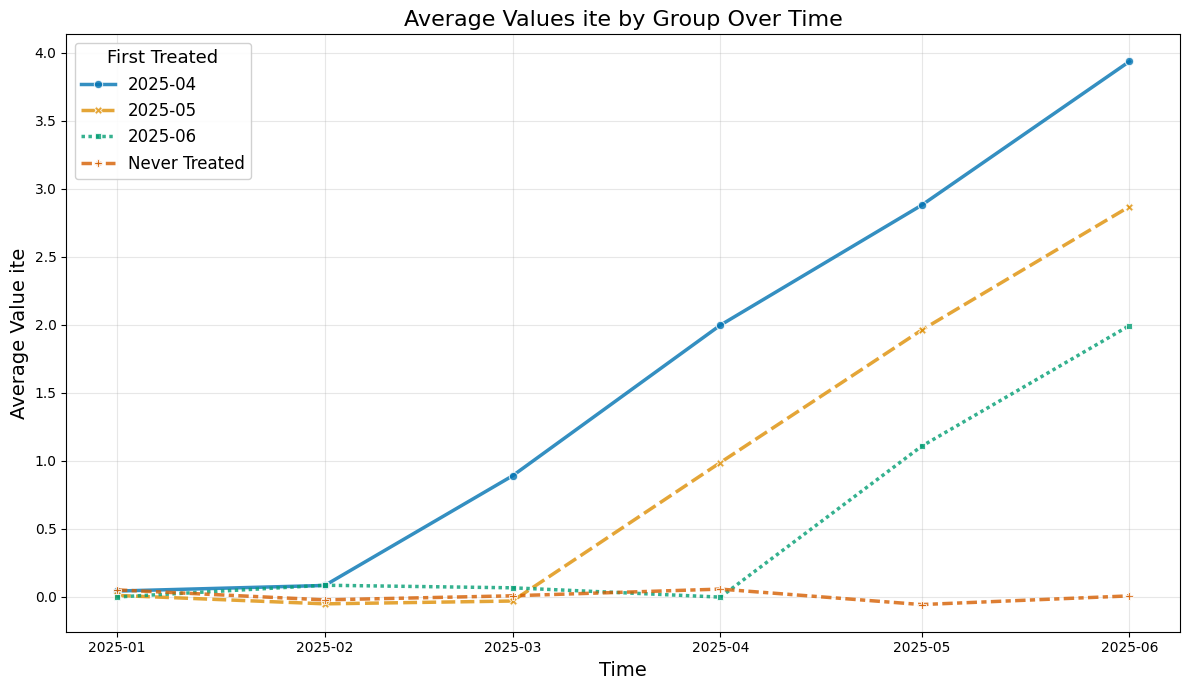

In [30]:
plot_data(agg_df_anticipation, col_name='ite')

Initialize a corresponding `DoubleMLPanelData` object.

In [31]:
dml_data_anticipation = DoubleMLPanelData(
    data=df_anticipation,
    y_col="y",
    d_cols="d",
    id_col="id",
    t_col="t",
    x_cols=["Z1", "Z2", "Z3", "Z4"],
    datetime_unit="M"
)

### ATT Estimation

Let us take a look at the estimation without anticipation.

/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/runner/work/doubleml-docs/doubleml-docs/doubleml-for-py/doubleml/double_ml.py:1443: UserWarning: The estimated nu2 for d is not positive. Re-estimation based on riesz representer (non-orthogonal).
  warnings.warn(msg, UserWarning)
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


(<Figure size 1200x800 with 4 Axes>,
 [<Axes: title={'center': 'First Treated: 2025-04'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-05'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-06'}, xlabel='Evaluation Period', ylabel='Effect'>])

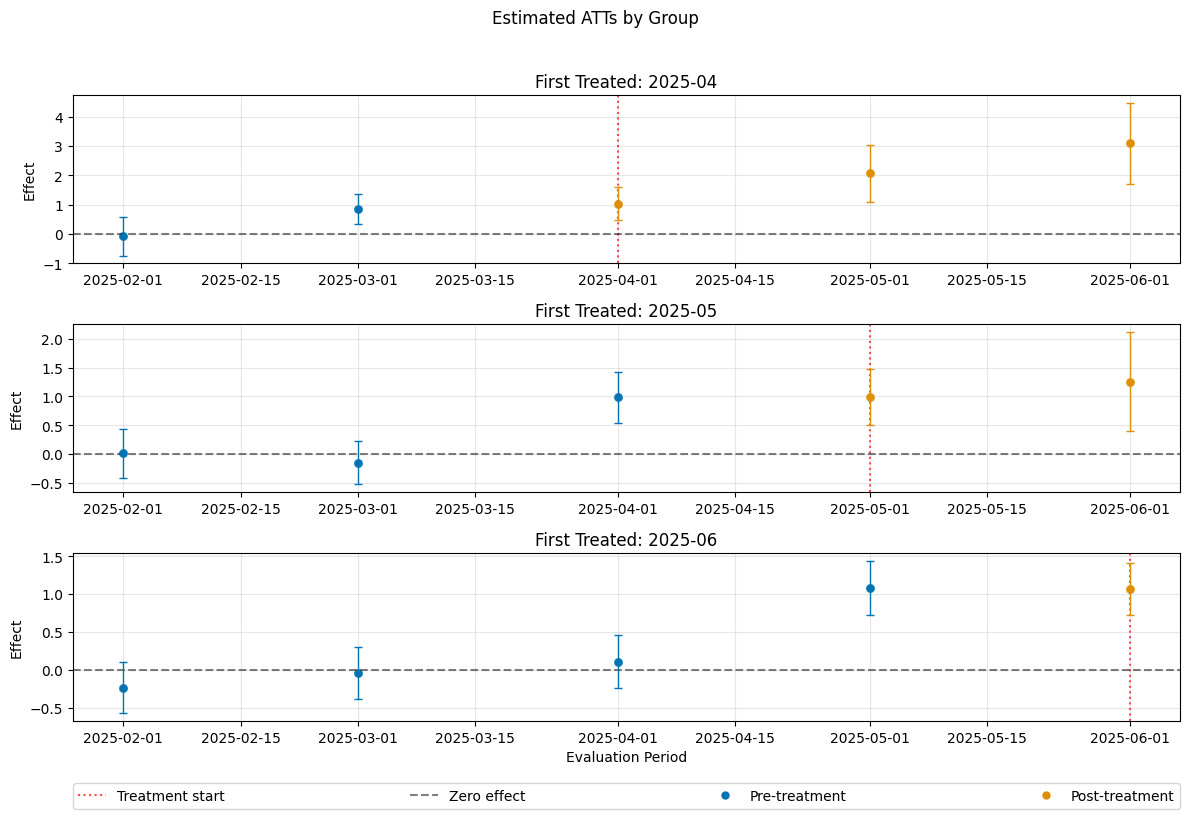

In [32]:
dml_obj_anticipation = DoubleMLDIDMulti(dml_data_anticipation, **default_args)
dml_obj_anticipation.fit()
dml_obj_anticipation.bootstrap(n_rep_boot=5000)
dml_obj_anticipation.plot_effects()

The effects are obviously biased. To include anticipation periods, one can adjust the `anticipation_periods` parameter. Correspondingly, the outcome regression (and not yet treated units) are adjusted.

/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/runner/work/doubleml-docs/doubleml-docs/doubleml-for-py/doubleml/double_ml.py:1443: UserWarning: The estimated nu2 for d is not positive. Re-estimation based on riesz representer (non-orthogonal).
  warnings.warn(msg, UserWarning)


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fut

(<Figure size 1200x800 with 4 Axes>,
 [<Axes: title={'center': 'First Treated: 2025-04'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-05'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-06'}, xlabel='Evaluation Period', ylabel='Effect'>])

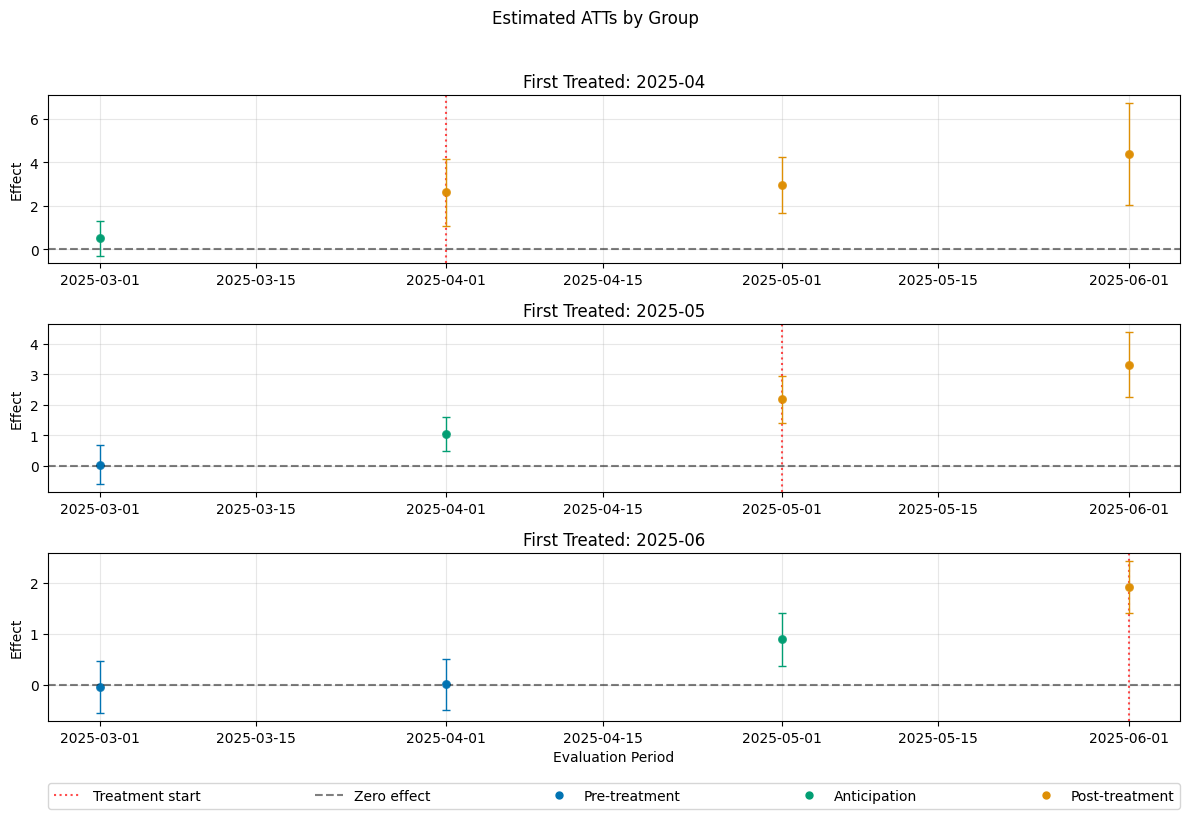

In [33]:
dml_obj_anticipation = DoubleMLDIDMulti(dml_data_anticipation, **(default_args| {"anticipation_periods": 1}))
dml_obj_anticipation.fit()
dml_obj_anticipation.bootstrap(n_rep_boot=5000)
dml_obj_anticipation.plot_effects()

## Group-Time Combinations

The default option `gt_combinations="standard"` includes all group time values with the specific choice of $t_\text{pre} = \min(\mathrm{g}, t_\text{eval}) - 1$ (without anticipation) which is the weakest possible parallel trend assumption.

Other options are possible or only specific combinations of $(\mathrm{g},t_\text{pre},t_\text{eval})$.

### All Combinations

The  option `gt_combinations="all"` includes all relevant group time values with $t_\text{pre} < \min(\mathrm{g}, t_\text{eval})$, including longer parallel trend assumptions.
This can result in multiple estimates for the same $ATT(\mathrm{g},t)$, which have slightly different assumptions (length of parallel trends).

/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


(<Figure size 1200x800 with 4 Axes>,
 [<Axes: title={'center': 'First Treated: 2025-04'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-05'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-06'}, xlabel='Evaluation Period', ylabel='Effect'>])

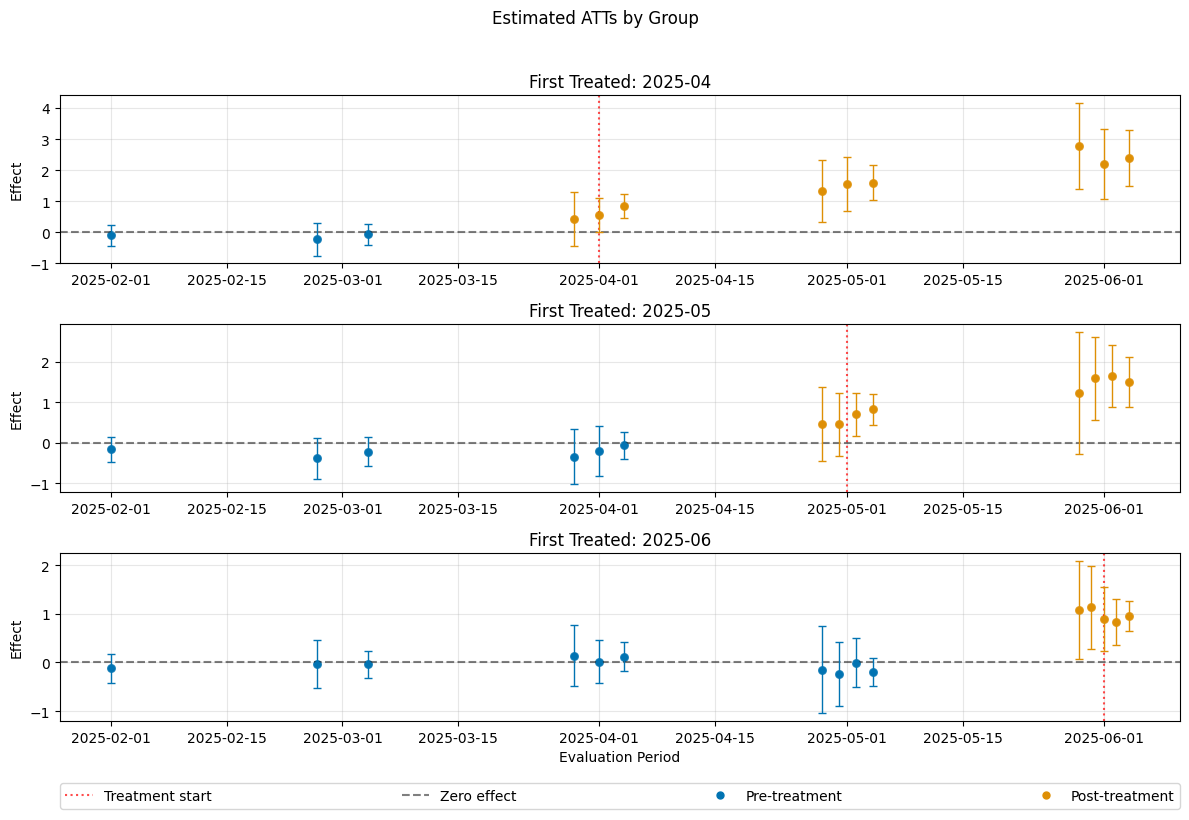

In [34]:
dml_obj_all = DoubleMLDIDMulti(dml_data, **(default_args| {"gt_combinations": "all"}))
dml_obj_all.fit()
dml_obj_all.bootstrap(n_rep_boot=5000)
dml_obj_all.plot_effects()

### Universal Base Period

The  option `gt_combinations="universal"` set $t_\text{pre} = \mathrm{g} - \delta - 1$, corresponding to a universal/constant comparison or base period.

Remark that this implies $t_\text{pre} > t_\text{eval}$ for all pre-treatment periods (accounting for anticipation). Therefore these effects do not have the same straightforward interpretation as ATT's.

/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


(<Figure size 1200x800 with 4 Axes>,
 [<Axes: title={'center': 'First Treated: 2025-04'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-05'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-06'}, xlabel='Evaluation Period', ylabel='Effect'>])

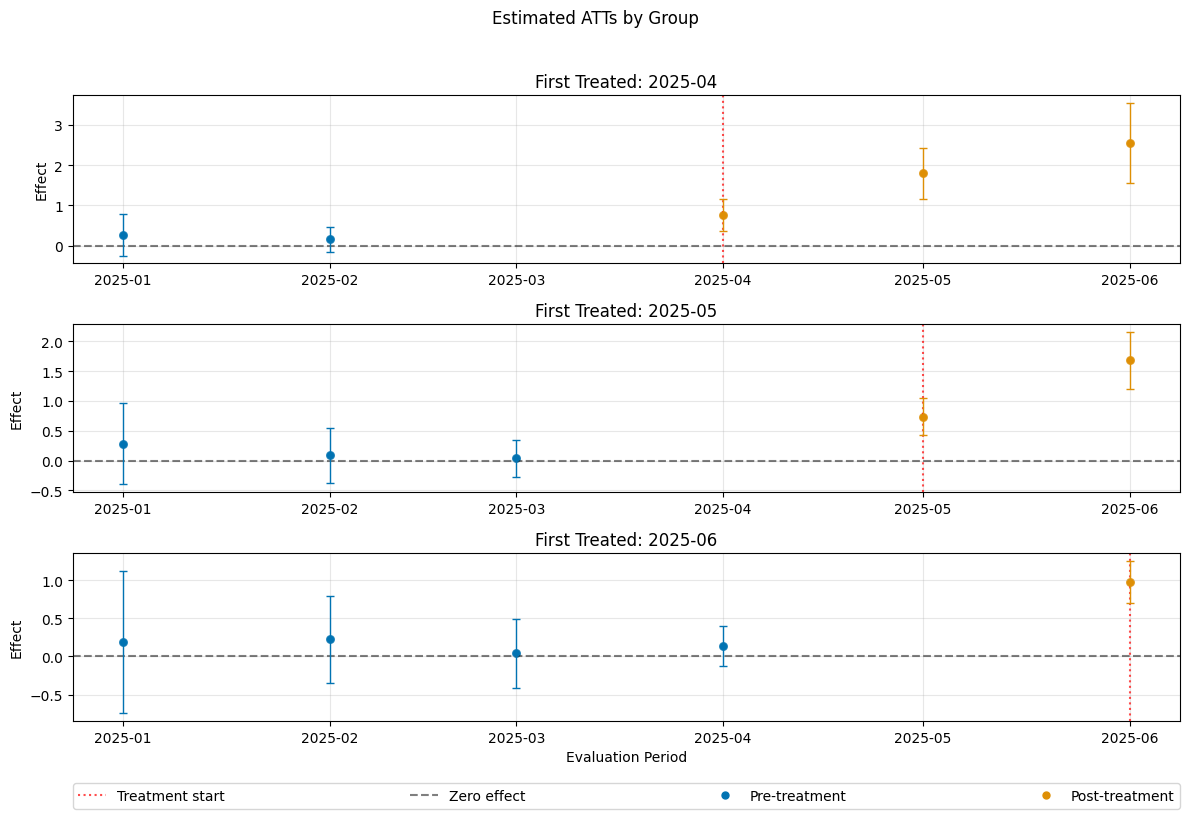

In [35]:
dml_obj_universal = DoubleMLDIDMulti(dml_data, **(default_args| {"gt_combinations": "universal"}))
dml_obj_universal.fit()
dml_obj_universal.bootstrap(n_rep_boot=5000)
dml_obj_universal.plot_effects()

### Selected Combinations

Instead it is also possible to just submit a list of tuples containing $(\mathrm{g}, t_\text{pre}, t_\text{eval})$ combinations. E.g. only two combinations

/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.12.12/x64/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


(<Figure size 1200x800 with 2 Axes>,
 [<Axes: title={'center': 'First Treated: 2025-04'}, xlabel='Evaluation Period', ylabel='Effect'>])

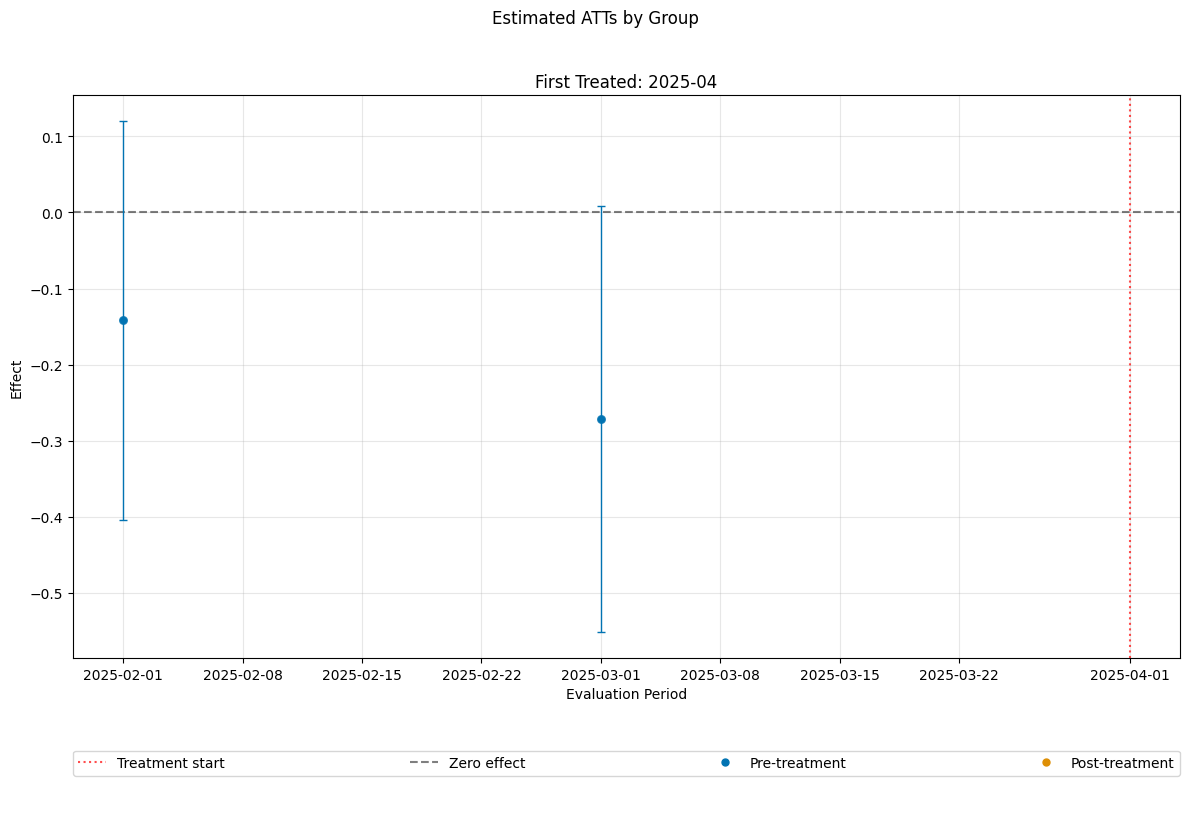

In [36]:
gt_dict = {
    "gt_combinations": [
        (np.datetime64('2025-04'),
         np.datetime64('2025-01'),
         np.datetime64('2025-02')),
        (np.datetime64('2025-04'),
         np.datetime64('2025-02'),
         np.datetime64('2025-03')),
    ]
}

dml_obj_all = DoubleMLDIDMulti(dml_data, **(default_args| gt_dict))
dml_obj_all.fit()
dml_obj_all.bootstrap(n_rep_boot=5000)
dml_obj_all.plot_effects()